# LEAR one-shot replication (PJM)

Minimal, clean notebook to replicate the published LEAR forecasts for the first test day (2016-12-27) and compare to the provided benchmark CSV.

Note, we were also able to self-replicate, in getting at the same point estimates as produced in notebook: `Notebooks/02_forecasting_models.ipynb` (written to `forecasts_local`).

In [50]:
import pandas as pd
df_PJM = pd.read_csv('datasets/hourly_data_all_markets.csv')
df_PJM = df_PJM[df_PJM['mkt'] == 'PJM']
actual_value = df_PJM[pd.to_datetime(df_PJM['DateTime']).dt.date == pd.to_datetime('2016-12-27').date()]['Price'].values.tolist()

## window = 1092

In [1]:
import importlib
import pandas as pd
import numpy as np

from epftoolbox.data import read_data
import epftoolbox.models._lear as _lear

# Ensure latest LEAR logic is loaded
importlib.reload(_lear)
from epftoolbox.models._lear import LEAR

# Official train/test split for PJM (2 test years as in the benchmark)
df_train, df_test = read_data(dataset='PJM', years_test=2, path='datasets')

target_date = pd.to_datetime('2016-12-27 00:00:00')
calibration_window = 1092  # 3-year window (LEAR 1092)

# Data available up to target day; hide target day prices for daily recalibration
data_available = pd.concat([df_train, df_test.loc[:target_date + pd.Timedelta(hours=23)]])
data_available.loc[target_date:target_date + pd.Timedelta(hours=23), 'Price'] = np.nan

model = LEAR(calibration_window=calibration_window)
prediction = model.recalibrate_and_forecast_next_day(
    df=data_available,
    next_day_date=target_date,
    calibration_window=calibration_window,
)

print(f"Prediction for {target_date.date()} (LEAR {calibration_window} days):")
print(list(prediction[0]))



2025-12-10 16:57:35.773716: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 16:57:35.797791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-10 16:57:35.797817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-10 16:57:35.798498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-10 16:57:35.802808: I tensorflow/core/platform/cpu_feature_guar

Prediction for 2016-12-27 (LEAR 1092 days):
[19.10084436280493, 18.264595052624454, 17.53075027173726, 17.434241164226606, 18.22410953667942, 19.85321601109398, 23.788848056333673, 25.228665817697696, 26.251532835112556, 27.419878156879065, 28.5286133462322, 28.063830938555824, 27.211335219793543, 26.745630089348808, 26.208890106713888, 26.338957625953665, 28.022927743149186, 35.886230846829605, 32.565618443229326, 31.739756707231756, 31.986765822896174, 28.9021473579299, 24.97601551255972, 22.516413026453357]


In [2]:
# Compare with published benchmark row
published = pd.read_csv('forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv')
published_row = published.loc[:24, 'LEAR 1092'].to_list()

print("Published LEAR 1092:")
print(published_row)



Published LEAR 1092:
[19.106, 18.2766, 17.4325, 17.44, 18.175, 19.8149, 23.511, 25.8432, 26.5383, 27.4225, 28.4752, 28.3429, 27.3322, 26.7224, 25.6884, 25.7518, 27.7477, 36.0018, 32.6576, 31.8707, 31.986, 28.6272, 24.8992, 22.5305, 21.9406]


## LEAR 56 (8 weeks)

Replicate the 56-day window variant for 2016-12-27.

Note on AIC/LARS: the built-in LEAR uses `LassoLarsIC` (AIC) per hour. That estimator needs `n_samples > n_features` (plus an intercept) after dropping the first week for lags. With a 56-day window, `n_features` ≈ 247 and usable days ≈ 49, so AIC can fail with “samples < features”. The code below keeps the 56-day intent, but if AIC raises, it automatically retries with the minimal window that satisfies `n_samples > n_features` so the fit can proceed without changing the core LEAR implementation.

In [3]:
calibration_window_56 = 56

data_available_56 = pd.concat([df_train, df_test.loc[:target_date + pd.Timedelta(hours=23)]])
data_available_56.loc[target_date:target_date + pd.Timedelta(hours=23), 'Price'] = np.nan

import warnings
from sklearn.exceptions import ConvergenceWarning
from epftoolbox.data import scaling
from sklearn.linear_model import Lasso

# Helper: LEAR variant that uses a fixed alpha instead of LARS/AIC (no code changes to _lear.py)
class LEARFixedAlpha(LEAR):
    def __init__(self, calibration_window, alpha_fixed):
        super().__init__(calibration_window=calibration_window)
        self._alpha_fixed = alpha_fixed

    def recalibrate(self, Xtrain, Ytrain):
        # Copied from LEAR.recalibrate, but using fixed alpha instead of LassoLarsIC
        [Ytrain], self.scalerY = scaling([Ytrain], 'Invariant')
        [Xtrain_no_dummies], self.scalerX = scaling([Xtrain[:, :-7]], 'Invariant')
        Xtrain[:, :-7] = Xtrain_no_dummies
        self.models = {}
        for h in range(24):
            model = Lasso(max_iter=2500, alpha=self._alpha_fixed)
            model.fit(Xtrain, Ytrain[:, h])
            self.models[h] = model

# Run with native AIC; if it fails (n_samples < n_features), retry with fixed alpha
try:
    model_56 = LEAR(calibration_window=calibration_window_56)
    prediction_56 = model_56.recalibrate_and_forecast_next_day(
        df=data_available_56,
        next_day_date=target_date,
        calibration_window=calibration_window_56,
    )
    alphas_56 = [model_56.models[h].alpha for h in range(24)]
    used_mode = "AIC"
    used_alpha = None
except ValueError:
    fixed_alpha = 1e-2  # slightly stronger shrinkage to help convergence
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model_56 = LEARFixedAlpha(calibration_window=calibration_window_56, alpha_fixed=fixed_alpha)
    prediction_56 = model_56.recalibrate_and_forecast_next_day(
        df=data_available_56,
        next_day_date=target_date,
        calibration_window=calibration_window_56,
    )
    alphas_56 = [fixed_alpha] * 24
    used_mode = "fixed_alpha"
    used_alpha = fixed_alpha

print(f"Prediction for {target_date.date()} (LEAR {calibration_window_56} days, mode={used_mode}, alpha={used_alpha}):")
print([round(x, 4) for x in prediction_56[0]])

print("Alphas (per hour):")
print(alphas_56)

published_56 = published.loc[:24, 'LEAR 56'].to_list()
print("Published LEAR 56:")
print(published_56)



Prediction for 2016-12-27 (LEAR 56 days, mode=fixed_alpha, alpha=0.01):
[19.4149, 18.7822, 18.0082, 18.4203, 18.8302, 20.9372, 30.5142, 30.914, 29.8121, 30.1394, 29.7398, 28.61, 26.8479, 26.5137, 25.8102, 25.6235, 27.932, 37.8666, 34.6457, 34.8369, 33.6476, 28.759, 24.2697, 22.0278]
Alphas (per hour):
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
Published LEAR 56:
[20.1291, 19.5229, 19.0085, 18.9757, 19.3679, 21.2564, 30.5556, 30.859, 29.8895, 30.2034, 30.031, 28.574, 26.8186, 26.2332, 25.5586, 25.5853, 27.9074, 38.0152, 35.327, 34.2065, 32.623000000000005, 28.5701, 24.3618, 21.9919, 21.1114]


### LEAR 84

In [4]:
calibration_window_84 = 84

data_available_84 = pd.concat([df_train, df_test.loc[:target_date + pd.Timedelta(hours=23)]])
data_available_84.loc[target_date:target_date + pd.Timedelta(hours=23), 'Price'] = np.nan

import warnings
from sklearn.exceptions import ConvergenceWarning
from epftoolbox.data import scaling
from sklearn.linear_model import Lasso

# Helper: LEAR variant that uses a fixed alpha instead of LARS/AIC (no code changes to _lear.py)
class LEARFixedAlpha(LEAR):
    def __init__(self, calibration_window, alpha_fixed):
        super().__init__(calibration_window=calibration_window)
        self._alpha_fixed = alpha_fixed

    def recalibrate(self, Xtrain, Ytrain):
        # Copied from LEAR.recalibrate, but using fixed alpha instead of LassoLarsIC
        [Ytrain], self.scalerY = scaling([Ytrain], 'Invariant')
        [Xtrain_no_dummies], self.scalerX = scaling([Xtrain[:, :-7]], 'Invariant')
        Xtrain[:, :-7] = Xtrain_no_dummies
        self.models = {}
        for h in range(24):
            model = Lasso(max_iter=2500, alpha=self._alpha_fixed)
            model.fit(Xtrain, Ytrain[:, h])
            self.models[h] = model

# Run with native AIC; if it fails (n_samples < n_features), retry with fixed alpha
try:
    model_84 = LEAR(calibration_window=calibration_window_84)
    prediction_84 = model_84.recalibrate_and_forecast_next_day(
        df=data_available_84,
        next_day_date=target_date,
        calibration_window=calibration_window_84,
    )
    alphas_84 = [model_84.models[h].alpha for h in range(24)]
    used_mode = "AIC"
    used_alpha = None
except ValueError:
    fixed_alpha = 1e-2  # slightly stronger shrinkage to help convergence
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model_84 = LEARFixedAlpha(calibration_window=calibration_window_84, alpha_fixed=fixed_alpha)
    prediction_84 = model_84.recalibrate_and_forecast_next_day(
        df=data_available_84,
        next_day_date=target_date,
        calibration_window=calibration_window_84,
    )
    alphas_84 = [fixed_alpha] * 24
    used_mode = "fixed_alpha"
    used_alpha = fixed_alpha

print(f"Prediction for {target_date.date()} (LEAR {calibration_window_84} days, mode={used_mode}, alpha={used_alpha}):")
print([round(x, 4) for x in prediction_84[0]])

print("Alphas (per hour):")
print(alphas_84)

published_84 = published.loc[:24, 'LEAR 84'].to_list()
print("Published LEAR 84:")
print(published_84)



Prediction for 2016-12-27 (LEAR 84 days, mode=fixed_alpha, alpha=0.01):
[20.373, 19.1589, 18.5919, 18.911, 19.3572, 20.0788, 28.957, 31.821, 29.8934, 30.1757, 30.0602, 28.6828, 26.9199, 26.3157, 25.4317, 25.7163, 27.6039, 36.2432, 34.3367, 33.4044, 32.5971, 27.549, 24.6472, 22.7236]
Alphas (per hour):
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
Published LEAR 84:
[20.7366, 19.5459, 18.9345, 19.2347, 19.877, 20.584, 30.0478, 33.2934, 30.1701, 30.5597, 30.4527, 29.0341, 27.233, 26.6065, 25.8365, 25.7167, 27.3243, 37.0358, 34.7939, 33.6156, 32.6022, 28.5273, 24.7556, 22.7229, 21.2841]


# DNN one-shot replication (PJM)

## DNN one-shot (lookup from published forecasts)

The repo does not ship the DNN weights/training code for a quick one-shot run here. To inspect the published DNN outputs (e.g., DNN 1) for 2016-12-27, we can read them from the benchmark forecasts CSV.


In [6]:
# Load published forecasts and show DNN 1 for the target date
forecast_csv = 'forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv'
df_pub = pd.read_csv(forecast_csv)

# Extract first day (2016-12-27) 24-hour DNN 1
print("Published DNN 1 (2016-12-27):")
print(df_pub.loc[:24, 'DNN 1'].to_list())



Published DNN 1 (2016-12-27):
[19.70612335205078, 18.578807830810547, 17.405715942382812, 16.994461059570312, 18.000518798828125, 20.2280216217041, 24.20281219482422, 26.076431274414062, 25.93037223815918, 26.751548767089844, 27.29048156738281, 26.98875617980957, 26.584705352783203, 26.50397682189941, 26.20037651062012, 26.297685623168945, 28.09921264648437, 35.058292388916016, 32.93193817138672, 30.90234375, 28.85091018676757, 26.48240089416504, 24.27153396606445, 22.61918830871582, 22.26004409790039]


## DNN one-shot with hyperparameter search

DNN starts with a pre-selected set of hyperparamters. In this one-shot demo, we first conduct the search and then create DNN prediction.


In [ ]:
# with max_evals = 5 - runtime = 2min
# Next, increase max_evals to 50 to see if DNN fit can improve.

# Hyperparameter search for one-shot DNN (trimmed for speed)
import os
from pathlib import Path
from epftoolbox.models import hyperparameter_optimizer

exp_id = 'oneshot_dnn'
data_path = Path('datasets')
work_path = Path('experimental_files')
work_path.mkdir(parents=True, exist_ok=True)

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = 4
years_test = 2
max_evals = 5  # small search; increase if needed

trials_file_name = (
    f'DNN_hyperparameters_nl{nlayers}_datPJM_YT{years_test}'
    f"{'_SF' if shuffle_train else ''}"
    f"{'_DA' if data_augmentation else ''}"
    f'_CW{calibration_window}_{exp_id}'
)
trials_path = work_path / trials_file_name

if trials_path.exists():
    print('Trials file already exists, skipping hyperparameter search:')
    print(trials_path)
else:
    print('Running a small hyperparameter search to create trials file...')
    hyperparameter_optimizer(
        path_datasets_folder=str(data_path),
        path_hyperparameters_folder=str(work_path),
        new_hyperopt=True,
        max_evals=max_evals,
        nlayers=nlayers,
        dataset='PJM',
        years_test=years_test,
        calibration_window=calibration_window,
        shuffle_train=bool(shuffle_train),
        data_augmentation=bool(data_augmentation),
        experiment_id=exp_id,
        begin_test_date=None,
        end_test_date=None,
    )
    print('Saved trials to:', trials_path)


Running a small hyperparameter search to create trials file...


2025-12-10 17:26:23.394234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-10 17:26:23.494322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-10 17:26:23.497671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-



Tested 1/5 iterations.
Best MAE - Validation Dataset
  MAE: 8.7 | sMAPE: 21.95 %

Best MAE - Test Dataset
  MAE: 5.7 | sMAPE: 21.01 %




Tested 2/5 iterations.
Best MAE - Validation Dataset
  MAE: 8.7 | sMAPE: 21.95 %

Best MAE - Test Dataset
  MAE: 5.7 | sMAPE: 21.01 %




Tested 3/5 iterations.
Best MAE - Validation Dataset
  MAE: 7.5 | sMAPE: 18.00 %

Best MAE - Test Dataset
  MAE: 4.6 | sMAPE: 17.34 %




Tested 4/5 iterations.
Best MAE - Validation Dataset
  MAE: 7.5 | sMAPE: 18.00 %

Best MAE - Test Dataset
  MAE: 4.6 | sMAPE: 17.34 %


Saved trials to: experimental_files/DNN_hyperparameters_nl2_datPJM_YT2_SF_CW4_oneshot_dnn


In [26]:
# Minimal DNN run for a single test day (2016-12-27)
from epftoolbox.models import evaluate_dnn_in_test_dataset

# Define a single-day test window
begin_test_date = '27/12/2016 00:00'
end_test_date = '27/12/2016 00:00'  # Trick for getting at one day estimate - begin_test_date = end_test_date, where the 24 data points are estimated anyways.

# This will train/recalibrate once and produce a forecast for that day only
import os
os.makedirs('forecasts_local', exist_ok=True)

forecast_dnn = evaluate_dnn_in_test_dataset(
    experiment_id=exp_id,  # must match the hyperopt run above
    path_datasets_folder='datasets',
    path_hyperparameter_folder='experimental_files',
    path_recalibration_folder='forecasts_local',
    dataset='PJM',
    years_test=2,  # ignored when begin/end are provided
    begin_test_date=begin_test_date,
    end_test_date=end_test_date,
    new_recalibration=True,  # force a fresh run instead of loading a prior CSV
)

# Show the 24-hour DNN forecast for 2016-12-27
print("DNN forecast for 2016-12-27 (single-day run):")
print(forecast_dnn.iloc[0].values.tolist())



Test datasets: 2016-12-27 00:00:00 - 2016-12-27 23:00:00


2016-12-27 - sMAPE: 8.73%  |  MAE: 2.241
DNN forecast for 2016-12-27 (single-day run):
[21.268295288085938, 20.096500396728516, 18.6993408203125, 17.74589729309082, 18.0262451171875, 20.045551300048828, 23.81264877319336, 26.414045333862305, 27.620441436767578, 28.97234344482422, 29.800622940063477, 29.6710205078125, 29.166107177734375, 28.728099822998047, 28.01664161682129, 27.479639053344727, 28.057626724243164, 30.74039077758789, 31.60965347290039, 31.919803619384766, 31.788719177246094, 28.760652542114258, 25.235897064208984, 22.904203414916992]


In [27]:
forecast_dnn

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-27,21.268295,20.0965,18.699341,17.745897,18.026245,20.045551,23.812649,26.414045,27.620441,28.972343,...,28.016642,27.479639,28.057627,30.740391,31.609653,31.919804,31.788719,28.760653,25.235897,22.904203


In [28]:
# Now, print out the columns for the chosen date - 2016-12-27
chosen_date = '2016-12-27'
# Filter the DataFrame to rows matching the chosen date
# Filter to rows for the chosen date
chosen_day_rows = published[published['Unnamed: 0'].str.startswith(chosen_date)]
# Select only the 'D1' to 'D4' columns and transpose them
chosen_day_d1_to_d4_transposed = chosen_day_rows[["DNN 1", "DNN 2", "DNN 3", "DNN 4"]].transpose()
# Print all columns for that day
chosen_day_d1_to_d4_transposed

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DNN 1,19.706123,18.578808,17.405716,16.994461,18.000519,20.228022,24.202812,26.076431,25.930372,26.751549,...,26.200377,26.297686,28.099213,35.058292,32.931938,30.902344,28.850910,26.482401,24.271534,22.619188
DNN 2,19.040689,18.628008,17.954073,17.322933,18.452641,20.440174,23.291067,24.964016,25.283371,25.792505,...,24.917231,24.875704,26.216167,32.241158,30.142319,27.851013,27.114426,25.712709,23.455555,21.299164
DNN 3,19.661985,18.581722,17.564003,16.941095,17.457172,19.158525,22.370064,24.356388,25.467987,26.748640,...,25.531353,25.147465,27.194950,33.391148,31.513958,29.097511,28.769260,26.781998,23.786240,22.003754
DNN 4,18.857361,17.804329,16.387474,15.673610,15.920693,18.623030,22.651892,24.700928,24.950792,25.070341,...,23.515644,23.333128,25.200039,31.157816,30.578306,28.333342,28.451826,26.250410,23.073729,21.108505


In [ ]:
import pandas as pd
df_PJM = pd.read_csv('datasets/hourly_data_all_markets.csv')
df_PJM = df_PJM[df_PJM['mkt'] == 'PJM']
actual_value = df_PJM[pd.to_datetime(df_PJM['DateTime']).dt.date == pd.to_datetime('2016-12-27').date()]['Price'].values.tolist()

In [53]:
import pandas as pd

dataLabels = ['rerun', 'DNN 1', 'DNN 2', 'DNN 3', 'DNN 4', 'actual']
styling_of_plots = ['--', '-', '-', '-', '-', ':']  # Last one distinctly dotted for 'actual'
df = pd.DataFrame([
    forecast_dnn.iloc[0].values.tolist(),
    *chosen_day_d1_to_d4_transposed.values.tolist(),
    actual_value
], index=dataLabels)

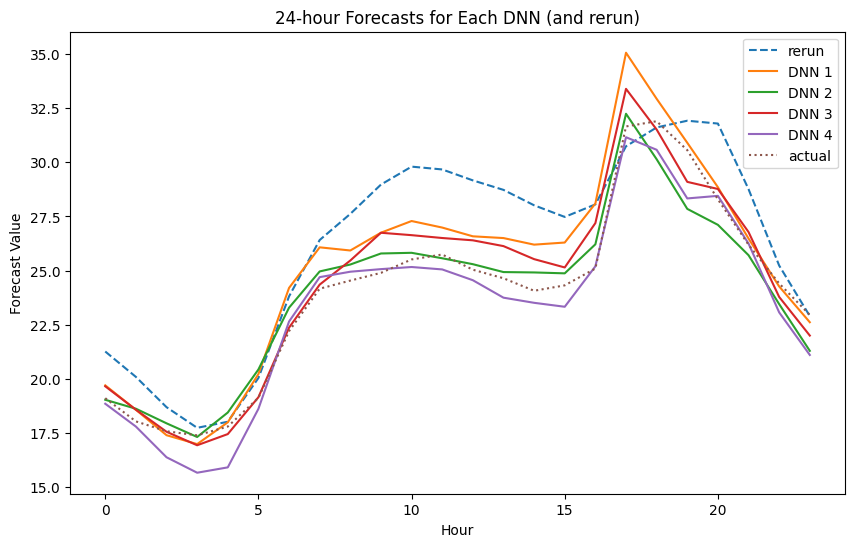

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, (idx, row) in enumerate(df.iterrows()):
    plt.plot(row.values, label=idx, linestyle=styling_of_plots[i])
plt.xlabel("Hour")
plt.ylabel("Forecast Value")
plt.title("24-hour Forecasts for Each DNN (and rerun)")
plt.legend()
plt.show()